### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports successful")

✅ Imports successful


### Load Data Splits

In [2]:
# Load preprocessed splits
train = pd.read_csv("../data/processed/train.csv")
val = pd.read_csv("../data/processed/val.csv")
test = pd.read_csv("../data/processed/test.csv")

print("Loaded data splits:")
print(f"Train: {train.shape}")
print(f"Val:   {val.shape}")
print(f"Test:  {test.shape}")
print(f"\nStroke distribution:")
print(f"Train: {train['stroke'].mean()*100:.2f}%")
print(f"Val:   {val['stroke'].mean()*100:.2f}%")
print(f"Test:  {test['stroke'].mean()*100:.2f}%")

Loaded data splits:
Train: (3066, 11)
Val:   (1022, 11)
Test:  (1022, 11)

Stroke distribution:
Train: 4.86%
Val:   4.89%
Test:  4.89%


### Handle Missing Values

In [3]:
# Handle missing BMI (using TRAIN median)
train_bmi_median = train['bmi'].median()

train['bmi'] = train['bmi'].fillna(train_bmi_median)
val['bmi'] = val['bmi'].fillna(train_bmi_median)
test['bmi'] = test['bmi'].fillna(train_bmi_median)

print(f"✅ Filled missing BMI with TRAIN median: {train_bmi_median:.2f}")

✅ Filled missing BMI with TRAIN median: 28.10


### Separate Features and Target

In [4]:
# Separate X and y for all sets
X_train = train.drop(columns=['stroke'])
y_train = train['stroke']

X_val = val.drop(columns=['stroke'])
y_val = val['stroke']

X_test = test.drop(columns=['stroke'])
y_test = test['stroke']

print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")

X_train: (3066, 10)
X_val:   (1022, 10)
X_test:  (1022, 10)


### Define Preprocessor

In [5]:
# Define feature types
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'hypertension', 'heart_disease', 
                   'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

print("✅ Preprocessor defined")

✅ Preprocessor defined


### K-Fold Cross-Validation

In [6]:
# K-fold cross-validation on TRAIN set only
print("="*60)
print("K-FOLD CROSS-VALIDATION (k=5)")
print("="*60)

# Combine train + val for cross-validation
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

print(f"Full training set: {X_full_train.shape}")

# Define models
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=100, 
                                             min_samples_leaf=50, class_weight='balanced', 
                                             random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, 
                                             min_samples_split=100, min_samples_leaf=50,
                                             class_weight='balanced', random_state=42, n_jobs=-1))
    ])
}

# Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation results
cv_results = {}

for model_name, model in models.items():
    print(f"\n{model_name}:")
    
    # Cross-validation scores (ROC AUC)
    scores = cross_val_score(model, X_full_train, y_full_train, 
                            cv=kfold, scoring='roc_auc', n_jobs=-1)
    
    cv_results[model_name] = scores
    
    print(f"  Fold scores: {scores}")
    print(f"  Mean AUC: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

print("="*60)

K-FOLD CROSS-VALIDATION (k=5)
Full training set: (4088, 10)

Logistic Regression:
  Fold scores: [0.86728792 0.83071979 0.82525707 0.78073298 0.86882239]
  Mean AUC: 0.8346 (+/- 0.0648)

Decision Tree:
  Fold scores: [0.82503213 0.81928021 0.781009   0.77425681 0.84293758]
  Mean AUC: 0.8085 (+/- 0.0529)

Random Forest:
  Fold scores: [0.84296272 0.84334833 0.80729434 0.79678334 0.86766409]
  Mean AUC: 0.8316 (+/- 0.0519)


### Cross-Validation Results Visualization

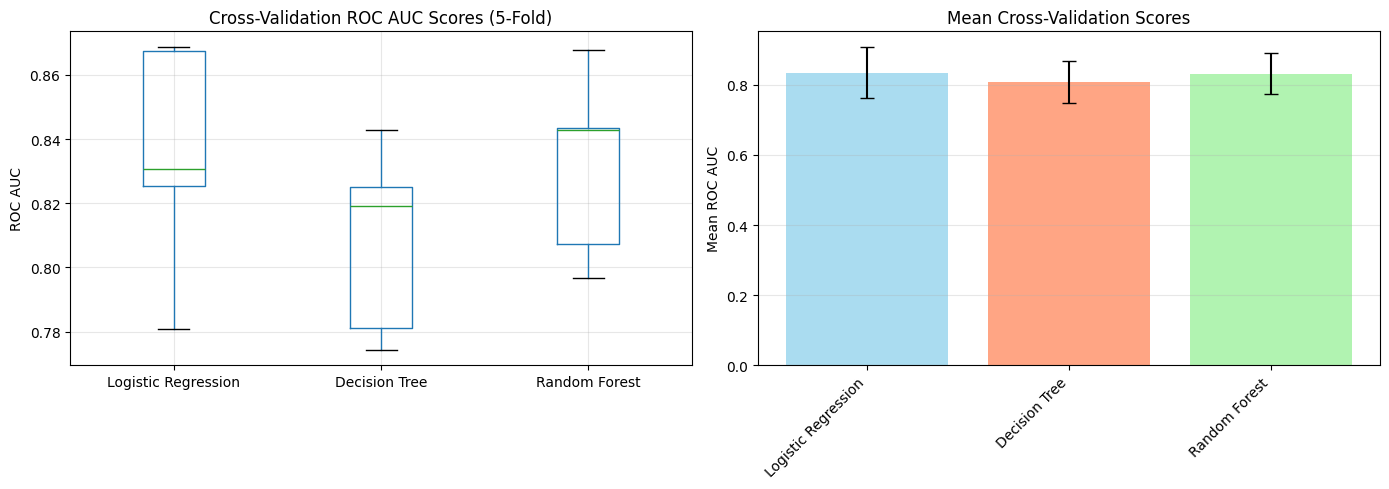


Cross-Validation Summary:
       Logistic Regression  Decision Tree  Random Forest
count             5.000000       5.000000       5.000000
mean              0.834564       0.808503       0.831611
std               0.036207       0.029597       0.029029
min               0.780733       0.774257       0.796783
25%               0.825257       0.781009       0.807294
50%               0.830720       0.819280       0.842963
75%               0.867288       0.825032       0.843348
max               0.868822       0.842938       0.867664


In [7]:
# Visualize CV results
cv_df = pd.DataFrame(cv_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
cv_df.boxplot(ax=axes[0])
axes[0].set_title('Cross-Validation ROC AUC Scores (5-Fold)')
axes[0].set_ylabel('ROC AUC')
axes[0].grid(alpha=0.3)

# Mean scores with error bars
means = cv_df.mean()
stds = cv_df.std()
x_pos = np.arange(len(means))

axes[1].bar(x_pos, means, yerr=stds*2, capsize=5, alpha=0.7, color=['skyblue', 'coral', 'lightgreen'])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(means.index, rotation=45, ha='right')
axes[1].set_ylabel('Mean ROC AUC')
axes[1].set_title('Mean Cross-Validation Scores')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nCross-Validation Summary:")
print(cv_df.describe())

### Train Best Model on Full Training Set

In [8]:
# Select best model (Logistic Regression based on your results)
print("="*60)
print("TRAINING BEST MODEL ON FULL TRAINING SET")
print("="*60)

best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Train on train+val
best_model.fit(X_full_train, y_full_train)

print("✅ Best model (Logistic Regression) trained on full training set")

TRAINING BEST MODEL ON FULL TRAINING SET
✅ Best model (Logistic Regression) trained on full training set


### Final Evaluation on TEST Set

In [9]:
# Final evaluation on TEST set (untouched until now)
print("="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

# Predictions on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test ROC AUC:   {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")

print("\n" + "="*60)
print("CLASSIFICATION REPORT (Test Set)")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['No Stroke', 'Stroke']))

FINAL EVALUATION ON TEST SET
Test Accuracy:  0.7456
Test ROC AUC:   0.8437
Test Precision: 0.1379
Test Recall:    0.8000
Test F1 Score:  0.2353

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

   No Stroke       0.99      0.74      0.85       972
      Stroke       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022



### Test Set Confusion Matrix

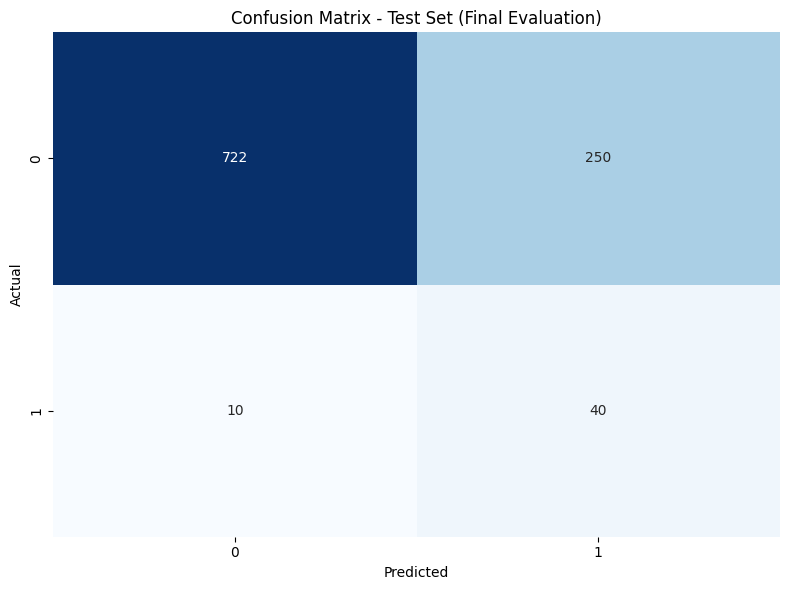


Confusion Matrix Breakdown:
True Negatives (TN):   722
False Positives (FP):  250
False Negatives (FN):   10
True Positives (TP):    40

Specificity (True Negative Rate): 0.7428
Sensitivity (True Positive Rate): 0.8000


In [10]:
# Confusion matrix on test set
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Set (Final Evaluation)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN):  {cm[0,0]:4d}")
print(f"False Positives (FP): {cm[0,1]:4d}")
print(f"False Negatives (FN): {cm[1,0]:4d}")
print(f"True Positives (TP):  {cm[1,1]:4d}")

# Calculate rates
tn, fp, fn, tp = cm.ravel()
print(f"\nSpecificity (True Negative Rate): {tn/(tn+fp):.4f}")
print(f"Sensitivity (True Positive Rate): {tp/(tp+fn):.4f}")

### ROC Curve (Test Set)

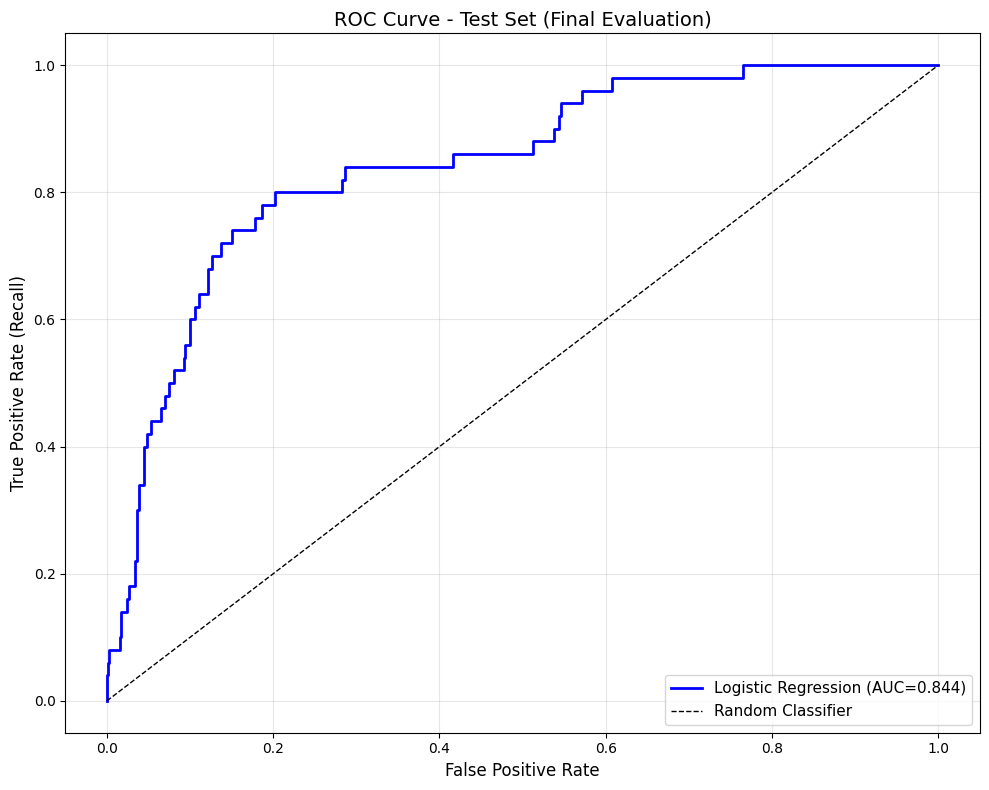

Area Under ROC Curve (Test): 0.8437


In [11]:
# ROC curve on test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC={test_auc:.3f})', linewidth=2, color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Test Set (Final Evaluation)', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Area Under ROC Curve (Test): {test_auc:.4f}")

### Precision-Recall Curve

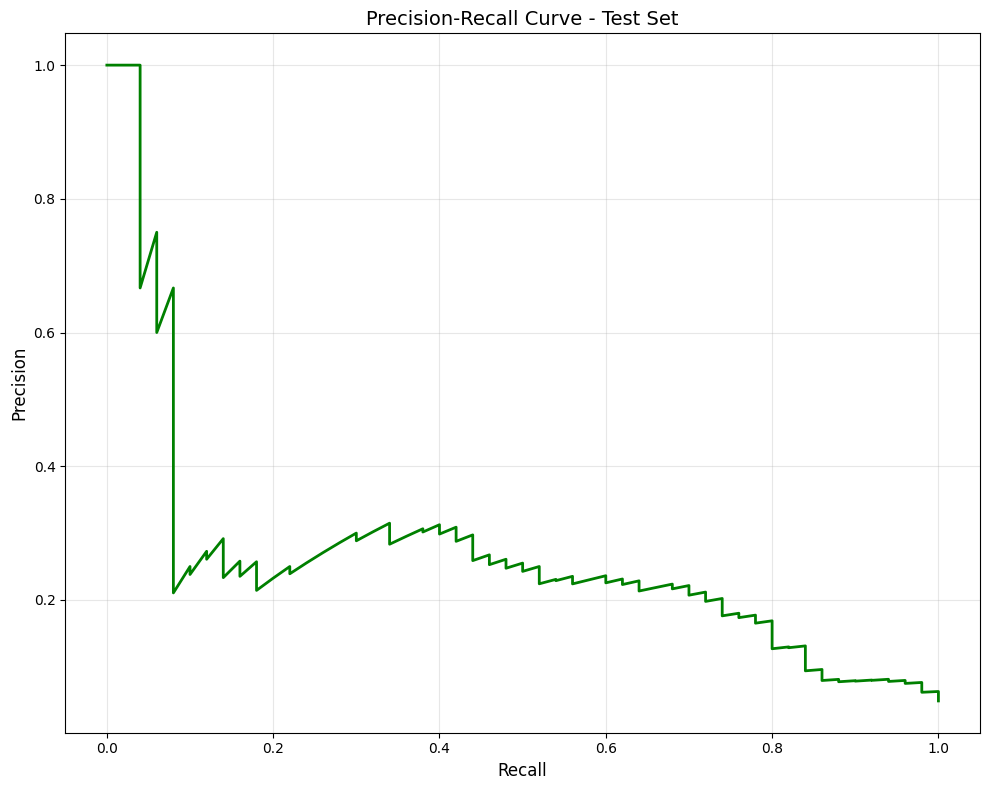

Test Precision: 0.1379
Test Recall:    0.8000
Test F1 Score:  0.2353


In [12]:
# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linewidth=2, color='green')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Test Set', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")

### Save Final Model

In [13]:
# Save final model trained on full training set
import os

os.makedirs("../models", exist_ok=True)
final_model_path = "../models/final_model.pkl"

with open(final_model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"✅ Final model saved to {final_model_path}")

# Save test metrics
test_metrics = {
    'model': 'Logistic Regression (Final)',
    'test_accuracy': test_acc,
    'test_roc_auc': test_auc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1
}

print("\n✅ Test metrics:")
for key, value in test_metrics.items():
    if key != 'model':
        print(f"  {key}: {value:.4f}")

✅ Final model saved to ../models/final_model.pkl

✅ Test metrics:
  test_accuracy: 0.7456
  test_roc_auc: 0.8437
  test_precision: 0.1379
  test_recall: 0.8000
  test_f1: 0.2353
